## Introduction

The name of housing unit types are specific of the Italian market, therefore I create a short dictionary with its translation in English:
- Monolocale: studio flat(one-room apartment)
- Bilocale: two-rooms apartment       
- Trilocale: three-rooms apartment       
- Quadrilocale: four-rooms apartment
- Appartamento: flat/apartment (that is from four to more rooms) 
- Attico: attic           
- Villa: house/villa
- Palazzo: building/palace
- Mansarda: mansard        
- Loft: loft apartment       
- Terratetto: this is a typical italian building of the early year of the 20th century. It means "from the ground to the roof"      
- Open space: open space apartment  
- Casale: farmhouse

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import math
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

## Data Acquisition

In [2]:
#Here the 20 csv generated from the Web scraping script I used are uploaded and then concatenated in one unique dataframe called df_italia

df_1 = pd.read_csv('01_rent_milano.csv')
df_2 = pd.read_csv('02_rent_roma.csv')
df_3 = pd.read_csv('03_rent_torino.csv')
df_4 = pd.read_csv('04_rent_genova.csv')
df_5 = pd.read_csv('05_rent_napoli.csv')

df_6 = pd.read_csv('06_rent_palermo.csv')
df_7 = pd.read_csv('07_rent_bologna.csv')
df_8 = pd.read_csv('08_rent_firenze.csv')
df_9 = pd.read_csv('09_rent_bari.csv')
df_10 = pd.read_csv('10_rent_catania.csv')

df_11 = pd.read_csv('11_rent_verona.csv')
df_12 = pd.read_csv('12_rent_venezia.csv')
df_13 = pd.read_csv('13_rent_messina.csv')
df_14 = pd.read_csv('14_rent_padova.csv')
df_15 = pd.read_csv('15_rent_trieste.csv')

df_16 = pd.read_csv('16_rent_parma.csv')
df_17 = pd.read_csv('17_rent_brescia.csv')
df_18 = pd.read_csv('18_rent_prato.csv')
df_19 = pd.read_csv('19_rent_taranto.csv')
df_20 = pd.read_csv('20_rent_modena.csv')

In [3]:
df_italia = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10,
                      df_11, df_12, df_13, df_14, df_15, df_16, df_17, df_18, df_19, df_20], axis = 0)

In [4]:
df_italia.head()

,Index,Title description,Price,N_rooms,Surface,N_toilettes,Floor
0,1,"Appartamento via San Marco, Turati, Milano",8500.0,5+,250.0,3,3
1,2,"Monolocale via Benedetto Marcello, Buenos Aire...",1150.0,NaN,40.0,NaN,3
2,3,"Bilocale via Maddalena Donadoni Giudice 22, Bo...",900.0,2,51.0,NaN,3
3,4,"Bilocale via Larga 23, Missori, Milano",1550.0,2,55.0,NaN,3
4,5,"Bilocale via Giovanni Antonio Amadeo 40, Città...",920.0,2,45.0,NaN,3


In [5]:
df_italia.shape

(11395, 7)

### Feature engineering

In [6]:
# I create three new features City, Zone, and Housing unit from the original title description

df_italia['City'] = df_italia['Title description'].apply(lambda x: x.split()[-1])
df_italia['Zone'] = df_italia['Title description'].apply(lambda x: x.split(", ")[-2])

df_italia['Housing_unit'] = df_italia['Title description'].str.split(' ').str[0] 


In [7]:
df_italia.head()

,Index,Title description,Price,N_rooms,Surface,N_toilettes,Floor,City,Zone,Housing_unit
0,1,"Appartamento via San Marco, Turati, Milano",8500.0,5+,250.0,3,3,Milano,Turati,Appartamento
1,2,"Monolocale via Benedetto Marcello, Buenos Aire...",1150.0,NaN,40.0,NaN,3,Milano,Buenos Aires,Monolocale
2,3,"Bilocale via Maddalena Donadoni Giudice 22, Bo...",900.0,2,51.0,NaN,3,Milano,Bovisa,Bilocale
3,4,"Bilocale via Larga 23, Missori, Milano",1550.0,2,55.0,NaN,3,Milano,Missori,Bilocale
4,5,"Bilocale via Giovanni Antonio Amadeo 40, Città...",920.0,2,45.0,NaN,3,Milano,Città Studi,Bilocale


In [8]:
df_italia['City'].nunique(), df_italia['Zone'].nunique(), df_italia['Housing_unit'].nunique()

(20, 903, 19)

## Data Wrangling and Data Cleaning

In [9]:
df_italia.isnull().sum()

Index                   0
Title description       0
Price                 205
N_rooms              1372
Surface               190
N_toilettes          7519
Floor                  25
City                    0
Zone                    0
Housing_unit            0
dtype: int64

In [10]:
df_italia['City'].value_counts()

Milano     2000
Roma       2000
Torino     1596
Firenze     966
Bologna     841
Genova      728
Napoli      633
Palermo     451
Parma       279
Venezia     273
Verona      246
Padova      213
Modena      206
Messina     199
Catania     187
Trieste     177
Brescia     138
Bari        126
Taranto      93
Prato        43
Name: City, dtype: int64

#### Zone

In [11]:
#Here, there are visibile anomalies, such as 'Trilocale sant eufemia', that must be corrected. 
#I'm gonna look for such errors through all cities and fix them.
df_italia['Zone'].value_counts()

Centro Storico              403
Crocetta                    147
Via Roma                    124
Duomo                        96
Vomero                       88
                           ... 
Trilocale sant eufemia        1
Bilocale p.tta Nogara         1
Parona                        1
Bilocale Ponte Scaligero      1
San Carlo - San Gregorio      1
Name: Zone, Length: 903, dtype: int64

In [12]:
#These lines of code were used to replace anomalies in the "zone" name. Sometimes it weren't specified the zone name in the 'Title description' 
#and therefore it was taken the address and compared among the neighborhoods of the specific city.

#Milano
df_italia["Zone"] = df_italia["Zone"].replace(['Bilocale via Col di Lana 1'], 'Ticinese',regex=True)

#Roma
df_italia["Zone"] = df_italia["Zone"].replace(['Trilocale via Albalonga'], 'Re di Roma' )

#Torino
df_italia["Zone"] = df_italia["Zone"].replace(['143'], 'Santa Rita' )
df_italia["Zone"] = df_italia["Zone"].replace(['Appartamento in villa madonna del pilone'], 'Santa Rita' )

#Genova
df_italia["Zone"] = df_italia["Zone"].replace(['Trilocale via Gabriele Rossetti 6'], 'Quarto' )
df_italia = df_italia[df_italia["Zone"] != 'secondo piano']

#Napoli
df_italia["Zone"] = df_italia["Zone"].replace(['Appartamento via Niccolò Tommaseo ANGOLO via PARTENOPE'], 'Santa Lucia' )
df_italia["Zone"] = df_italia["Zone"].replace(['Palazzo - Edificio via Manzoni 44,'], 'Mergellina - Piedigrotta' )
df_italia["Zone"] = df_italia["Zone"].replace(['Palazzo - Edificio via Provinciale delle Puglie 302'], 'Arpino' )

#Firenze
df_italia["Zone"] = df_italia["Zone"].replace(['Appartamento Pian De Giullari'], 'Cinque Vie' )
df_italia["Zone"] = df_italia["Zone"].replace(['Appartamento piazza d\'Azeglio'], 'D\'Azeglio' )
df_italia = df_italia[df_italia["Zone"] != 'Attico 135 m² con terrazza']
df_italia = df_italia[df_italia["Zone"] != 'piano terra']

#Bari
df_italia["Zone"] = df_italia["Zone"].replace(['Villa unifamiliare via dei gerani'], 'San Paolo' )
df_italia["Zone"] = df_italia["Zone"].replace(['16'], 'Murat' )

#Verona
df_italia["Zone"] = df_italia["Zone"].replace(['Bilocale Ponte Scaligero'], 'Ponte Scaligero' )
df_italia["Zone"] = df_italia["Zone"].replace(['Bilocale p.tta Nogara'], 'Centro Storico' )
df_italia["Zone"] = df_italia["Zone"].replace(['Trilocale sant eufemia'], 'Centro Storico')

#Venezia
df_italia["Zone"] = df_italia["Zone"].replace(['Appartamento Giuseppe verdi'], 'Mestre' )
df_italia["Zone"] = df_italia["Zone"].replace(['Palazzo - Edificio Cannaregio Ca\'D\'Oro'], 'Cannaregio Ca\' D\'Oro')
df_italia = df_italia[df_italia["Zone"] != 'Palazzo - Edificio']

#Messina
df_italia["Zone"] = df_italia["Zone"].replace(['Monolocale fondachello'], 'Fondachello' )
df_italia["Zone"] = df_italia["Zone"].replace(['piano rialzato'], 'Sant\'Alessio' )

#Padova
df_italia = df_italia[df_italia["Zone"] != 'Monolocale San Pietro Viminario']
df_italia["Zone"] = df_italia["Zone"].replace(['Monolocale piazzetta Conciapelli'], 'Scrovegni' )
df_italia["Zone"] = df_italia["Zone"].replace(['Trilocale Villatora di Saonara'], 'Villatora di Saonara' )

#Trieste
df_italia["Zone"] = df_italia["Zone"].replace(['Trilocale borgo teresiano'], 'Borgo Teresiano' )
df_italia = df_italia[df_italia["Zone"] != 'Quadrilocale buono stato']

#Parma
df_italia = df_italia[df_italia["Zone"] != '420 m²'] 
df_italia["Zone"] = df_italia["Zone"].replace(['Appartamento 35 m²'], 'Centro Storico' )
df_italia["Zone"] = df_italia["Zone"].replace(['Trilocale via Zanardi'], 'Piazza Maestri' )
df_italia["Zone"] = df_italia["Zone"].replace(['primo piano'], 'Duomo' )

#Brescia
df_italia["Zone"] = df_italia["Zone"].replace(['Bilocale via Tosio 28'], 'Magenta - Arnaldo' )

#Prato
df_italia = df_italia[df_italia["Zone"] != 'Trilocale Vaiano'] 
df_italia = df_italia[df_italia["Zone"] != 'ottimo stato'] 

#Taranto
df_italia = df_italia[df_italia["Zone"] != 'Villa unifamiliare via dei Mandarini 11'] 

#Modena
df_italia = df_italia[df_italia["Zone"] != 'Monolocale Modena'] 


In [13]:
#This is an example of line of code was to check which were the anomalies in the "Zone" name. 
#By substituting the city name, you can check if there were anomalous zone names.

df_italia[df_italia['City'] =='Modena'].groupby(['Zone']).size().reset_index().iloc[0:60]

,Zone,0
0,Albareto - Mulini Nuovi,5
1,Baggiovara,4
2,Buon Pastore - Parco Amendola,11
3,Centro Storico,80
4,Cittanova - Marzaglia,6
5,Cognento,7
6,Crocetta,9
7,Madonnina - Tre Olmi,6
8,Modena Est,2
9,Morane - Contrada,3


#### Housing_unit

In [14]:
df_italia['Housing_unit'].value_counts()

Bilocale        3429
Trilocale       2700
Appartamento    1585
Quadrilocale    1502
Monolocale      1084
Attico           363
Villa            257
Palazzo          162
Mansarda         137
Loft              65
Terratetto        52
Open              19
Albergo           13
Casale             4
Casa               4
Loft,              3
Rustico            2
Soffitta           1
Cascina            1
Name: Housing_unit, dtype: int64

In [15]:
# Here, I fixed mistakes, aggregated into one when there were synonyms, 
# and deleted the element 'Albergo' (that is, Hotel) beacuse it is not a housing unit in which to live and so it is out of my research

df_italia["Housing_unit"] = df_italia["Housing_unit"].replace('Loft,', 'Loft')
df_italia["Housing_unit"] = df_italia["Housing_unit"].replace('Open', 'Open space')
df_italia["Housing_unit"] = df_italia["Housing_unit"].replace('Soffitta', 'Mansarda')
df_italia["Housing_unit"] = df_italia["Housing_unit"].replace(['Rustico', 'Cascina'], 'Casale')
df_italia["Housing_unit"] = df_italia["Housing_unit"].replace(['Casa'], 'Villa')
df_italia = df_italia[df_italia["Housing_unit"] != 'Albergo'] 


df_italia['Housing_unit'].value_counts()

Bilocale        3429
Trilocale       2700
Appartamento    1585
Quadrilocale    1502
Monolocale      1084
Attico           363
Villa            261
Palazzo          162
Mansarda         138
Loft              68
Terratetto        52
Open space        19
Casale             7
Name: Housing_unit, dtype: int64

#### Floor

In [16]:
df_italia['Floor'].unique() # we can see that some floor numbers are interger, while others are strings

array(['3', '15', '8', '5', '1', '2', '4', 'R', '0', '6', '7', '3 - 4',
       '1 - 2', '10', '4 - 5', '5 - 6', nan, 2, 6, 8, 0, 1, 3, 4, 5],
      dtype=object)

In [17]:
#I calculated the mode in order to replace NaN values
df_italia["Floor"].mode()

0    1
Name: Floor, dtype: object

In [18]:
# Here, I chose to turn all numerical and NaN elements into strings

df_italia["Floor"] = df_italia["Floor"].replace(0, '0')
df_italia["Floor"] = df_italia["Floor"].replace(1, '1')
df_italia["Floor"] = df_italia["Floor"].replace('1 - 2', '2')
df_italia["Floor"] = df_italia["Floor"].replace(2, '2')
df_italia["Floor"] = df_italia["Floor"].replace(3, '3')
df_italia["Floor"] = df_italia["Floor"].replace('3 - 4', '4')
df_italia["Floor"] = df_italia["Floor"].replace(4, '4')
df_italia["Floor"] = df_italia["Floor"].replace('4 - 5', '5')
df_italia["Floor"] = df_italia["Floor"].replace(5, '5')
df_italia["Floor"] = df_italia["Floor"].replace('5 - 6', '6')
df_italia["Floor"] = df_italia["Floor"].replace(6, '6')
df_italia["Floor"] = df_italia["Floor"].replace(8, '8')

# I was unable to replace the NaN values using fillna and the mode , so I chose to replace with the value 1 which is the mode
df_italia["Floor"] = df_italia["Floor"].replace(np.NaN, '1')


In [19]:
df_italia['Floor'].unique()

array(['3', '15', '8', '5', '1', '2', '4', 'R', '0', '6', '7', '10'],
      dtype=object)

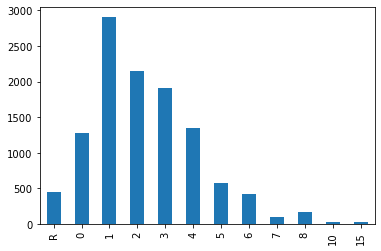

In [20]:
df_italia['Floor'].value_counts().reindex(['R','0','1','2','3','4','5','6','7','8','10','15']).plot(kind='bar');

#### N_rooms

In [21]:
# I chose to fill the NaN values of the feature N_rooms considering the mode of the specific type of housing unit, 
# therefore I filled Monolocale (1 room apartment) with 1, while the others with the most frequent element for that specific type of home

df_italia.loc[df_italia['Housing_unit']=='Monolocale','N_rooms'] = df_italia.loc[df_italia['Housing_unit']=='Monolocale','N_rooms'].fillna(value='1')
df_italia.loc[df_italia['Housing_unit']=='Appartamento','N_rooms'] = df_italia.loc[df_italia['Housing_unit']=='Appartamento','N_rooms'].fillna(value='5')
df_italia.loc[df_italia['Housing_unit']=='Attico','N_rooms'] = df_italia.loc[df_italia['Housing_unit']=='Attico','N_rooms'].fillna(value='3')
df_italia.loc[df_italia['Housing_unit']=='Casale','N_rooms'] = df_italia.loc[df_italia['Housing_unit']=='Casale','N_rooms'].fillna(value='3')
df_italia.loc[df_italia['Housing_unit']=='Loft','N_rooms'] = df_italia.loc[df_italia['Housing_unit']=='Loft','N_rooms'].fillna(value='2')
df_italia.loc[df_italia['Housing_unit']=='Mansarda','N_rooms'] = df_italia.loc[df_italia['Housing_unit']=='Mansarda','N_rooms'].fillna(value='2')
df_italia.loc[df_italia['Housing_unit']=='Open space','N_rooms'] = df_italia.loc[df_italia['Housing_unit']=='Open space','N_rooms'].fillna(value='2')
df_italia.loc[df_italia['Housing_unit']=='Palazzo','N_rooms'] = df_italia.loc[df_italia['Housing_unit']=='Palazzo','N_rooms'].fillna(value='5+')
df_italia.loc[df_italia['Housing_unit']=='Terratetto','N_rooms'] = df_italia.loc[df_italia['Housing_unit']=='Terratetto','N_rooms'].fillna(value='5+')
df_italia.loc[df_italia['Housing_unit']=='Villa','N_rooms'] = df_italia.loc[df_italia['Housing_unit']=='Villa','N_rooms'].fillna(value='5+')


In [22]:
df_italia.isnull().sum()

Index                   0
Title description       0
Price                 203
N_rooms                 0
Surface               190
N_toilettes          7508
Floor                   0
City                    0
Zone                    0
Housing_unit            0
dtype: int64

In [23]:
df_italia[['Housing_unit','N_rooms']].groupby(['Housing_unit','N_rooms']).value_counts()

Housing_unit  N_rooms
Appartamento  2             8
              3             5
              4             9
              5           885
              5+          678
Attico        2            62
              3           109
              4            72
              5            52
              5+           68
Bilocale      2          3429
Casale        3             4
              4             1
              5             1
              5+            1
Loft          2            49
              3            13
              4             3
              5             2
              5+            1
Mansarda      2            91
              3            31
              4            14
              5             2
Monolocale    1          1084
Open space    2            15
              3             3
              5+            1
Palazzo       2            12
              3             8
              4            32
              5            13
              5+  

#### Toilettes

In [24]:
# I dropped the Toilettes column because more than a half of the announcement miss this information and so I am unable to fill the missing values
df_italia.drop(columns='N_toilettes', axis = 1, inplace = True)

#### Price

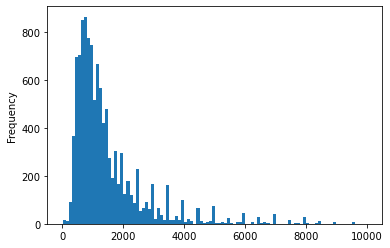

In [25]:
df_italia.Price.plot(kind = 'hist', bins = 100);

In [26]:
# I filled the missing values with the median because the distribution of Price is left skewed

price_median = df_italia.Price.median()

df_italia['Price'] = df_italia['Price'].fillna(value = price_median)

In [27]:
df_italia.isnull().sum()

Index                  0
Title description      0
Price                  0
N_rooms                0
Surface              190
Floor                  0
City                   0
Zone                   0
Housing_unit           0
dtype: int64

#### Surface

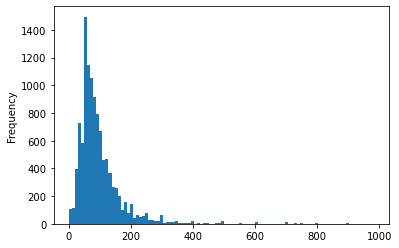

In [28]:
df_italia.Surface.plot(kind = 'hist', bins = 100);

In [29]:
df_italia.Surface.median(), df_italia.Surface.mean()

(78.0, 97.26048980322003)

In [30]:
# I filled the Nan values with the median because the distribution of Surface is left skewed

surface_median = df_italia.Surface.median()

df_italia['Surface'] = df_italia['Surface'].fillna(value = surface_median)

In [31]:
df_italia.isnull().sum()

Index                0
Title description    0
Price                0
N_rooms              0
Surface              0
Floor                0
City                 0
Zone                 0
Housing_unit         0
dtype: int64

In [32]:
# I dropped useless columns
df_italia = df_italia.drop(columns =['Index','Title description'], axis = 1)

## Explanatory Data Analysis

In [33]:
df_italia.head()

,Price,N_rooms,Surface,Floor,City,Zone,Housing_unit
0,8500.0,5+,250.0,3,Milano,Turati,Appartamento
1,1150.0,1,40.0,3,Milano,Buenos Aires,Monolocale
2,900.0,2,51.0,3,Milano,Bovisa,Bilocale
3,1550.0,2,55.0,3,Milano,Missori,Bilocale
4,920.0,2,45.0,3,Milano,Città Studi,Bilocale


#### Price

##### Observations:

- The average rent price is 1496€ per month, while the median value is 1100€.
- Most of the prices are below the 2,000€ per month, while a small percentange is above this threshold until picks between 8,000 and 10,000€ per month.
- The distribution of prices is left skewed.
- The most expensive housing units are avereagly: Villa, Palazzo, Attico, Terratetto and Appartamento; while the cheapest are Monolocale, Mansarda and Bilocale.
- Florence, Milan and Rome have the highest average rent price.
- The price was analyzed in relation with the five most frequent types of housing units: Monolocale, Bilocale, Trilocale, Quadrilocale, Appartmento.
- It emerged that the most costly are Appartamento and Quadrilocale, probably because they have the more rooms and a larger surface, followed by Trilocale. The cheapest are Monolocale and Bilocale.

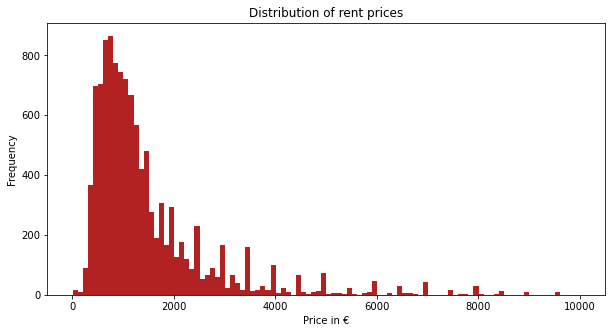

In [34]:
plt.figure(figsize=(10,5))
plt.title('Distribution of rent prices')
plt.hist(df_italia['Price'], bins = 100, color = 'firebrick')
plt.xlabel('Price in €')
plt.ylabel('Frequency');

In [35]:
df_italia['Price'].mean(), df_italia['Price'].median()

(1496.116798592788, 1100.0)

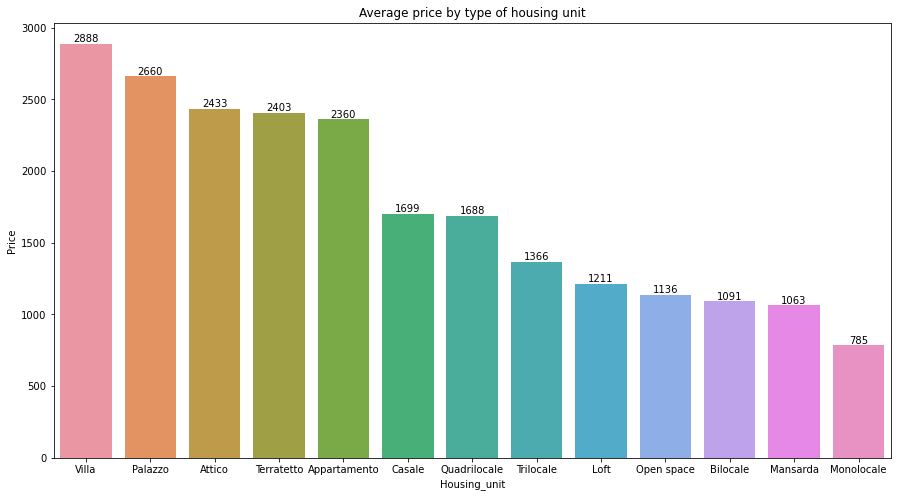

In [36]:
df_price = df_italia[['Housing_unit','Price']].groupby(['Housing_unit'])['Price'].mean().sort_values(ascending = False).round().reset_index()

plt.figure(figsize=(15, 8))
fig = sns.barplot(data = df_price, x = 'Housing_unit', y = 'Price')
plt.bar_label(fig.containers[0])
plt.title('Average price by type of housing unit');

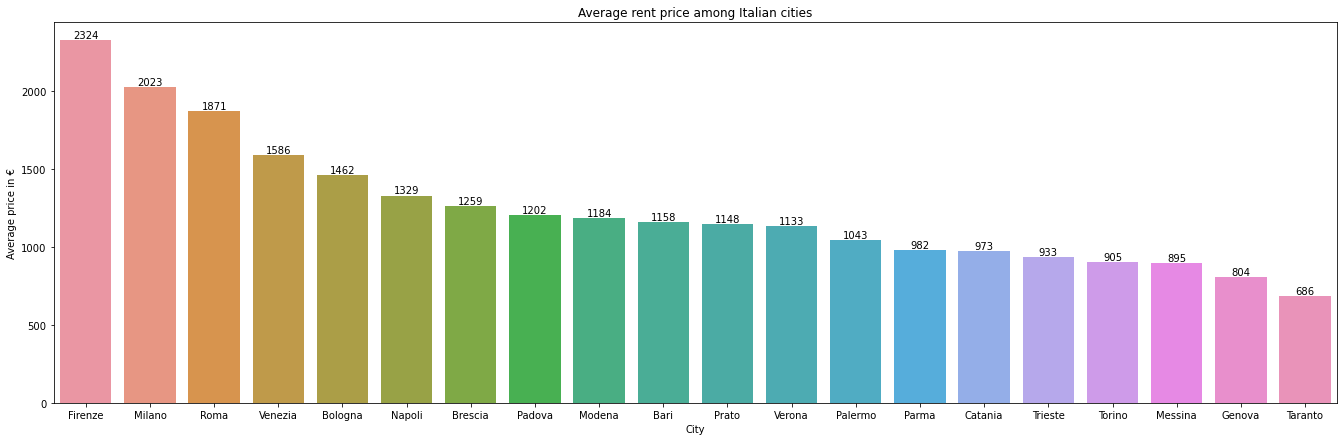

In [37]:
df_avg_price = df_italia[['City', 'Price']].groupby(['City'])['Price'].mean().sort_values(ascending = False).reset_index().round()

ax = plt.subplots(figsize=(23, 7))
splot = sns.barplot(data = df_avg_price, x = 'City', y = 'Price', ci = None)
plt.bar_label(splot.containers[0])
plt.title('Average rent price among Italian cities')
plt.ylabel('Average price in €');

In [38]:
df_housing_unit_filtered = df_italia[((df_italia.Housing_unit == 'Monolocale') | (df_italia.Housing_unit == 'Bilocale') | (df_italia.Housing_unit == 'Trilocale') |
                      (df_italia.Housing_unit == 'Quadrilocale') | (df_italia.Housing_unit == 'Appartamento')) &
                      ((df_italia.City == 'Roma') | (df_italia.City == 'Milano') | (df_italia.City == 'Torino') |
                      (df_italia.City == 'Firenze') | (df_italia.City == 'Bologna') | 
                      (df_italia.City == 'Genova') | (df_italia.City == 'Napoli') | (df_italia.City == 'Palermo'))]

df_housing_unit_filtered = df_housing_unit_filtered.round()
df_housing_unit_filtered.head()

,Price,N_rooms,Surface,Floor,City,Zone,Housing_unit
0,8500.0,5+,250.0,3,Milano,Turati,Appartamento
1,1150.0,1,40.0,3,Milano,Buenos Aires,Monolocale
2,900.0,2,51.0,3,Milano,Bovisa,Bilocale
3,1550.0,2,55.0,3,Milano,Missori,Bilocale
4,920.0,2,45.0,3,Milano,Città Studi,Bilocale


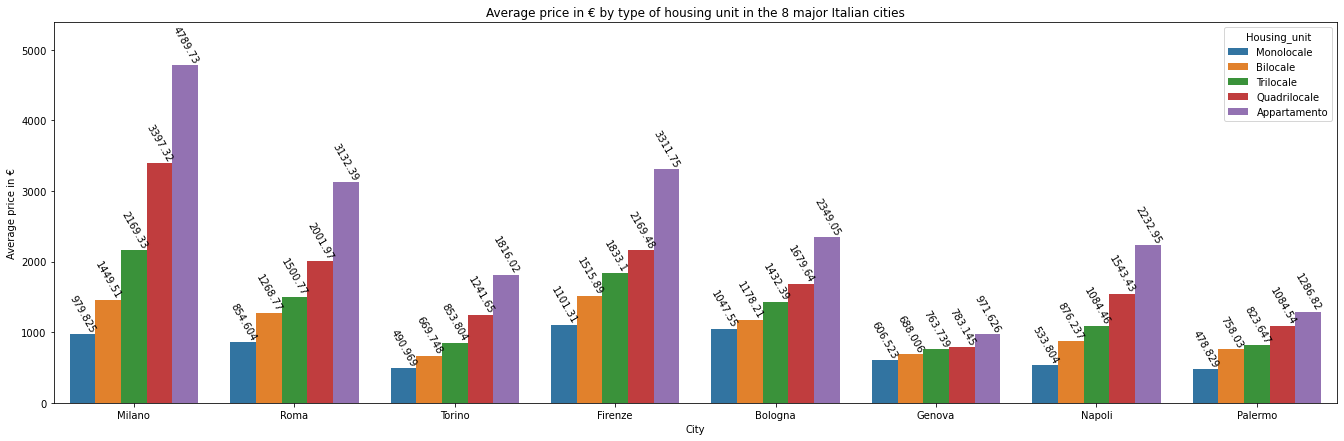

In [39]:
fig, ax = plt.subplots(figsize=(23, 7))
labels_ordered = ['Monolocale','Bilocale','Trilocale', 'Quadrilocale','Appartamento']
cities_ordered = ['Milano','Roma', 'Torino', 'Firenze', 'Bologna', 'Genova', 'Napoli', 'Palermo']
splot = sns.barplot(data = df_housing_unit_filtered, x = 'City', y = 'Price', hue = 'Housing_unit', order = cities_ordered, hue_order = labels_ordered , ax = ax, ci=None)
ax.bar_label(splot.containers[0], rotation=300)
ax.bar_label(splot.containers[1], rotation=300)
ax.bar_label(splot.containers[2], rotation=300)
ax.bar_label(splot.containers[3], rotation=300)
ax.bar_label(splot.containers[4], rotation=300)
plt.margins(y = 0.125)
plt.title('Average price in € by type of housing unit in the 8 major Italian cities')
plt.ylabel('Average price in €');

#### Surface

##### Observations:

- The average surface is 97 m², while the median value is 78 m².
- The cities with the highest average surface are Firenza, Catania and Roma, while those with the lowest are Torino, Bologna, and Trieste
- The housing unit type with the largest average surface are Villa, Terratetto and Appartamento, while those with the lowest are Monolocale, Bilocale and Mansarda.

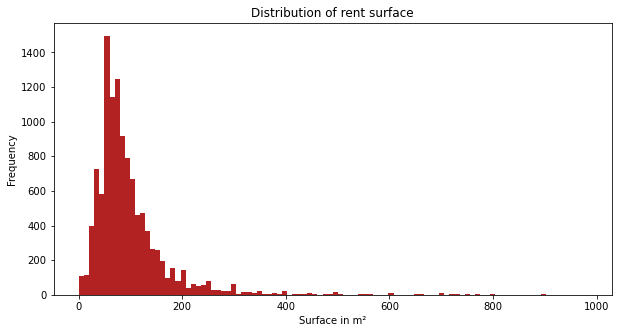

In [40]:
plt.figure(figsize=(10,5))
plt.title('Distribution of rent surface')
plt.hist(df_italia['Surface'], bins = 100, color = 'firebrick')
plt.xlabel('Surface in m²')
plt.ylabel('Frequency');

In [41]:
round(df_italia['Surface'].mean(),0), df_italia['Surface'].median()

(97.0, 78.0)

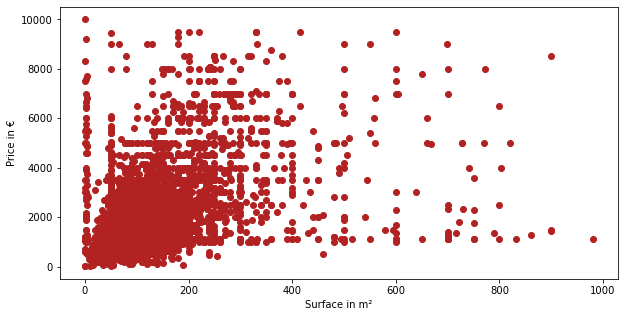

In [42]:
plt.figure(figsize=(10,5))
plt.scatter(df_italia['Surface'],df_italia['Price'], color = 'firebrick')
plt.xlabel('Surface in m²')
plt.ylabel('Price in €');

In [43]:
df_avg_surface_city = df_italia[['City','Surface']].groupby(['City'])['Surface'].mean().sort_values(ascending=False).reset_index()

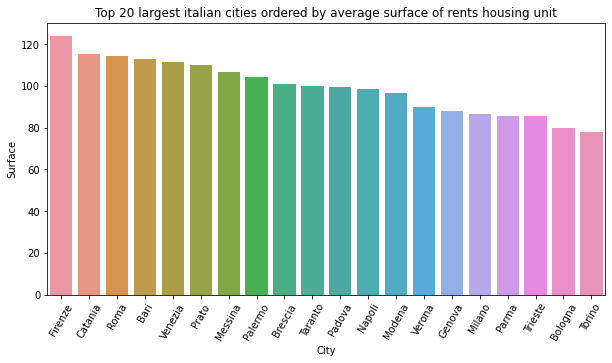

In [44]:
plt.figure(figsize=(10,5))
sns.barplot(data = df_avg_surface_city, x = 'City', y = 'Surface')
plt.xticks(rotation = 60)
plt.title('Top 20 largest italian cities ordered by average surface of rents housing unit');

In [45]:
df_avg_surface_housing_unit = round(df_italia[['City', 'Housing_unit', 'Surface']].groupby(['Housing_unit'])['Surface'].mean().sort_values(ascending=False).reset_index(),0)
df_avg_surface_housing_unit

,Housing_unit,Surface
0,Villa,289.0
1,Terratetto,191.0
2,Appartamento,170.0
3,Casale,152.0
4,Palazzo,147.0
5,Attico,139.0
6,Quadrilocale,118.0
7,Trilocale,88.0
8,Open space,70.0
9,Loft,70.0


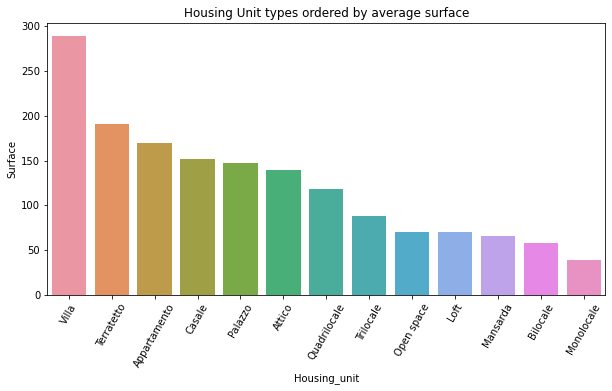

In [46]:
plt.figure(figsize=(10,5))
sns.barplot(data = df_avg_surface_housing_unit, x = 'Housing_unit', y = 'Surface')
plt.xticks(rotation = 60)
plt.title('Housing Unit types ordered by average surface');

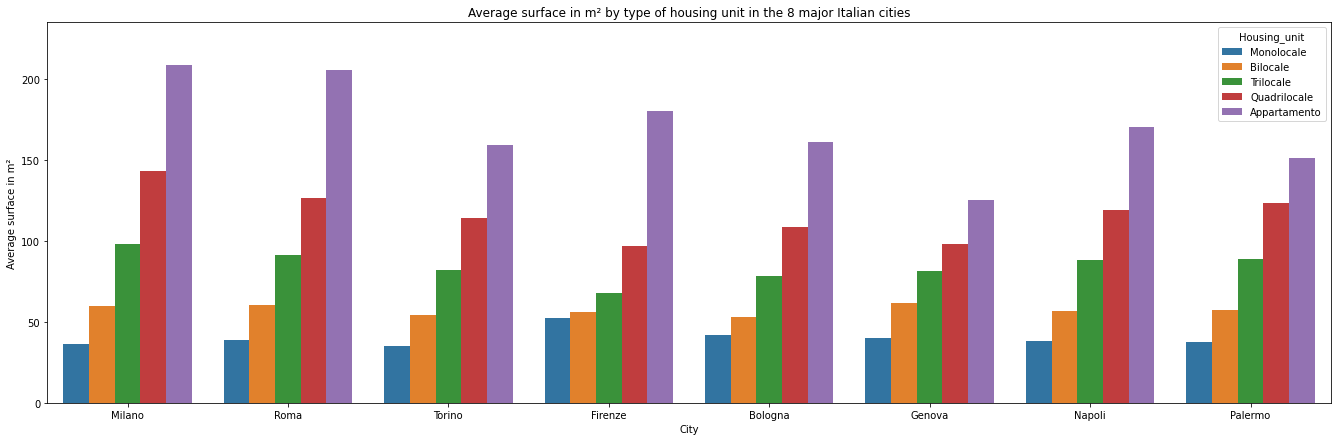

In [47]:
fig, ax = plt.subplots(figsize=(23, 7))
labels_ordered = ['Monolocale','Bilocale','Trilocale', 'Quadrilocale','Appartamento']
cities_ordered = ['Milano','Roma', 'Torino', 'Firenze', 'Bologna', 'Genova', 'Napoli', 'Palermo']
splot = sns.barplot(data = df_housing_unit_filtered, x = 'City', y = 'Surface', hue = 'Housing_unit', order = cities_ordered, hue_order = labels_ordered , ax = ax, ci=None)

plt.margins(y = 0.125)
plt.title('Average surface in m² by type of housing unit in the 8 major Italian cities')
plt.ylabel('Average surface in m²');

#### N_rooms

##### Observations:

- the most frequent number of rooms in a renting house: 2-rooms (3676), 3-rooms (2902), 4-rooms (1671) 

- Cities with most:
        
        - Monolocale-type flat: Torino(228), Milano(183), Bologna (161)
        
        - Bilocale-type flat: Milano (897), Torino (551), Roma (541)
        
        - Trilocale-type flat: Milano (515), Roma (512), Torino (352)
        
        - Quadrilocale-type flat: Roma (261), Milano (172), Torino (162)
        
        - Apartments: Roma (269), Firenze (263), Torino(164), Genova (163)

In [48]:
rooms = df_italia.groupby(['N_rooms']).size().reset_index().rename(columns = {0: 'Num'})
rooms

,N_rooms,Num
0,1,1084
1,2,3676
2,3,2902
3,4,1671
4,5,998
5,5+,1039


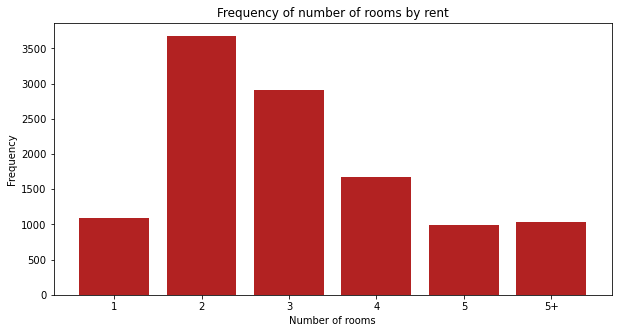

In [49]:
plt.figure(figsize=(10,5))
plt.title('Frequency of number of rooms by rent')
fig = plt.bar(rooms['N_rooms'], rooms['Num'], color = 'firebrick')

plt.xlabel('Number of rooms')
plt.ylabel('Frequency');

In [50]:
# Here, I found the most frequent number of rooms by city
df_italia[['City','N_rooms']].groupby(['City'])['N_rooms'].agg(pd.Series.mode)

City
Bari            2
Bologna         2
Brescia         3
Catania         2
Firenze        5+
Genova          3
Messina         3
Milano          2
Modena     [2, 4]
Napoli          2
Padova          2
Palermo         2
Parma           2
Prato           2
Roma            3
Taranto         3
Torino          2
Trieste         2
Venezia         3
Verona          2
Name: N_rooms, dtype: object

In [51]:
df_monolocali = df_italia[df_italia['Housing_unit']=='Monolocale']
df_monolocali[['City','N_rooms']].groupby(['City'])['N_rooms'].count().sort_values(ascending = False).reset_index().head(5)

,City,N_rooms
0,Torino,228
1,Milano,183
2,Bologna,161
3,Roma,134
4,Firenze,81


In [52]:
df_bilocali = df_italia[df_italia['Housing_unit']=='Bilocale']
df_bilocali[['City','N_rooms']].groupby(['City'])['N_rooms'].count().sort_values(ascending = False).reset_index().head(5)

,City,N_rooms
0,Milano,897
1,Torino,551
2,Roma,541
3,Bologna,238
4,Firenze,190


In [53]:
df_trilocali = df_italia[df_italia['Housing_unit']=='Trilocale']
df_trilocali[['City','N_rooms']].groupby(['City'])['N_rooms'].count().sort_values(ascending = False).reset_index().head(5)

,City,N_rooms
0,Milano,515
1,Roma,512
2,Torino,352
3,Bologna,199
4,Genova,180


In [54]:
df_trilocali = df_italia[df_italia['Housing_unit']=='Trilocale']
df_trilocali[['City','N_rooms']].groupby(['City'])['N_rooms'].count().sort_values(ascending = False).reset_index().head(5)

,City,N_rooms
0,Milano,515
1,Roma,512
2,Torino,352
3,Bologna,199
4,Genova,180


In [55]:
df_locals = df_italia[['City','Housing_unit','N_rooms']].groupby(['Housing_unit','City'])['N_rooms'].count().reset_index()

df_locals = df_locals[((df_locals.Housing_unit == 'Monolocale') | (df_locals.Housing_unit == 'Bilocale') | (df_locals.Housing_unit == 'Trilocale') |
                      (df_locals.Housing_unit == 'Quadrilocale') | (df_locals.Housing_unit == 'Appartamento')) &
                      ((df_locals.City == 'Roma') | (df_locals.City == 'Milano') | (df_locals.City == 'Torino') |
                      (df_locals.City == 'Firenze') | (df_locals.City == 'Bologna') | 
                      (df_locals.City == 'Genova') | (df_locals.City == 'Napoli') | (df_locals.City == 'Palermo'))]
df_locals.head(5)

,Housing_unit,City,N_rooms
1,Appartamento,Bologna,84
4,Appartamento,Firenze,263
5,Appartamento,Genova,163
7,Appartamento,Milano,107
9,Appartamento,Napoli,110


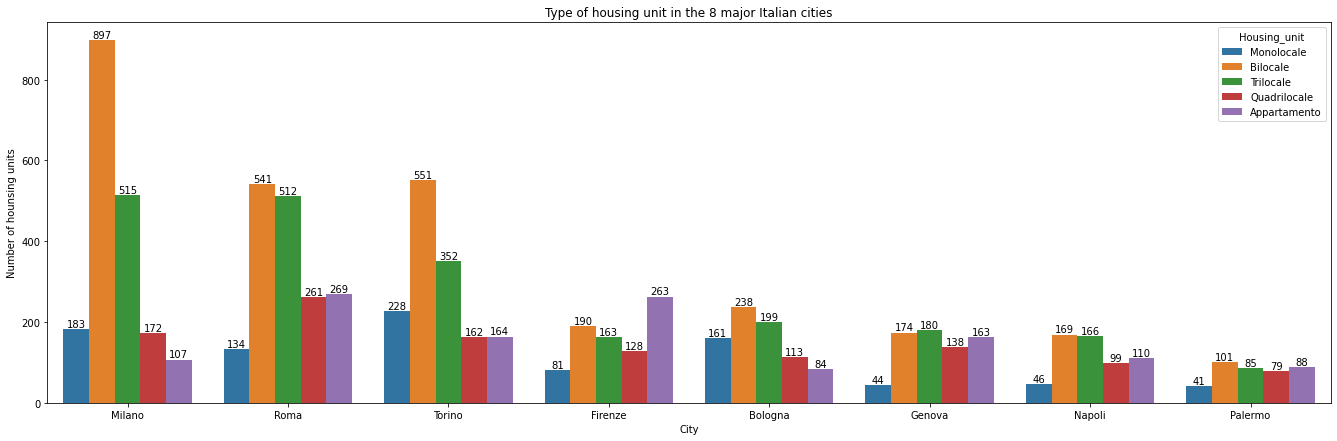

In [56]:
fig, ax = plt.subplots(figsize=(23, 7))
labels_ordered = ['Monolocale','Bilocale','Trilocale', 'Quadrilocale','Appartamento']
cities_ordered = ['Milano','Roma', 'Torino', 'Firenze', 'Bologna', 'Genova', 'Napoli', 'Palermo']
splot = sns.barplot(data = df_locals, x = 'City', y = 'N_rooms', hue = 'Housing_unit', order = cities_ordered, hue_order = labels_ordered , ax = ax)
plt.bar_label(splot.containers[0])
plt.bar_label(splot.containers[1])
plt.bar_label(splot.containers[2])
plt.bar_label(splot.containers[3])
plt.bar_label(splot.containers[4])
plt.title('Type of housing unit in the 8 major Italian cities')
plt.ylabel('Number of hounsing units');

#### Floor

In [57]:
df_italia['Floor'] = pd.Categorical(df_italia['Floor'], ['R', '0','1','2','3','4','5','6','7','8','10','15'])
floors = df_italia.groupby(['Floor']).size().reset_index().rename(columns = {0: 'Num'})
floors

,Floor,Num
0,R,452
1,0,1279
2,1,2907
3,2,2145
4,3,1913
5,4,1351
6,5,574
7,6,425
8,7,99
9,8,175


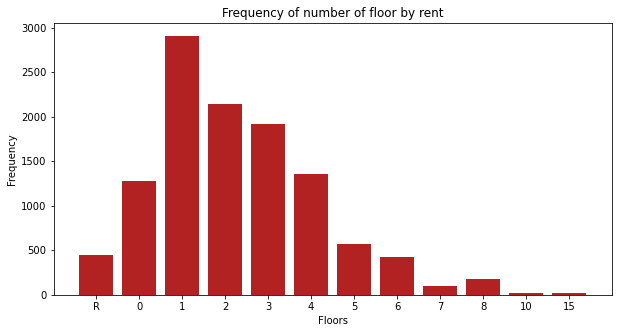

In [58]:
plt.figure(figsize=(10,5))
plt.title('Frequency of number of floor by rent')
fig = plt.bar(floors['Floor'], floors['Num'], color = 'firebrick')
plt.xlabel('Floors')
plt.ylabel('Frequency');

#### City

##### Observations:

- The cities with most announcements on Immobiliare.it are Roma, Milano, and Torino; while those the less announcements are Prato, Taranto, and Bari
- The cities with the most expansive average rent price are Firenze, Milano, and Roma; while those with the lowest are Taranto, Genova, Messina

In [59]:
city = df_italia.groupby(['City']).size().sort_values(ascending = False).reset_index().rename(columns = {0: 'Num'})
city

,City,Num
0,Roma,1999
1,Milano,1999
2,Torino,1596
3,Firenze,960
4,Bologna,841
5,Genova,727
6,Napoli,630
7,Palermo,451
8,Parma,278
9,Venezia,268


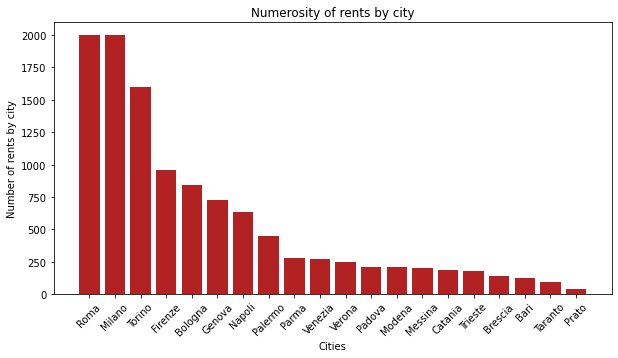

In [60]:
plt.figure(figsize=(10,5))
plt.title('Numerosity of rents by city')
fig = plt.bar(city['City'], city['Num'], color = 'firebrick')
plt.xlabel('Cities')
plt.ylabel('Number of rents by city')
plt.xticks(rotation = 45);

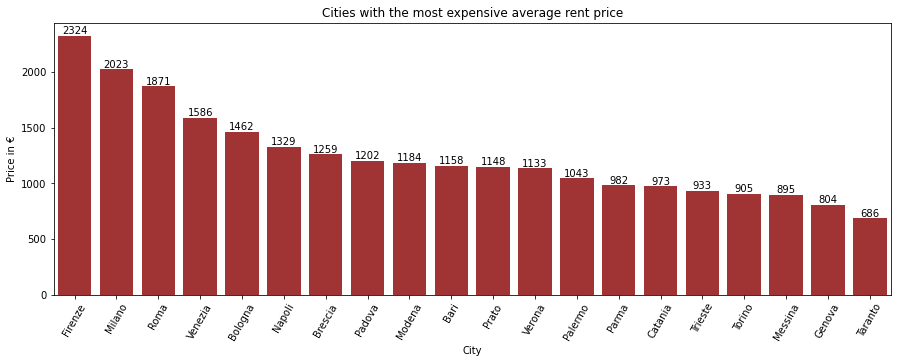

In [61]:
df_most_expensive_cities = df_italia[['City','Price']].groupby(['City'])['Price'].mean().round().reset_index().sort_values(by ='Price', ascending=False)

plt.figure(figsize=(15,5))
fig = sns.barplot(data = df_most_expensive_cities, x='City', y='Price', color='firebrick')
plt.bar_label(fig.containers[0])
plt.title('Cities with the most expensive average rent price')
plt.ylabel('Price in €')
plt.xticks(rotation = 60);

#### Zone

Here, there are some graphs that rank the most expensive city zones in Italy, and then the zones with the highest average price and the highest number of announcements in Milano, Roma, Torino, Bologna, and Firenze

In [62]:
#Most expensive rent zone in Italy
df_zone = df_italia[['City','Zone','Price']].groupby(['City','Zone'])['Price'].mean().round().sort_values(ascending=False).reset_index().head(15)
df_zone

,City,Zone,Price
0,Milano,Borgogna - Largo Augusto,7000.0
1,Milano,Susa,6500.0
2,Roma,Appia Pignatelli,6500.0
3,Firenze,Chiantigiana - Ponte a Ema,6000.0
4,Bari,Torre a Mare,6000.0
5,Venezia,Cannaregio Ca' D'Oro,5000.0
6,Milano,Turati,4717.0
7,Roma,Colle Oppio,4517.0
8,Firenze,Centro,4500.0
9,Brescia,Chiesanuova,4396.0


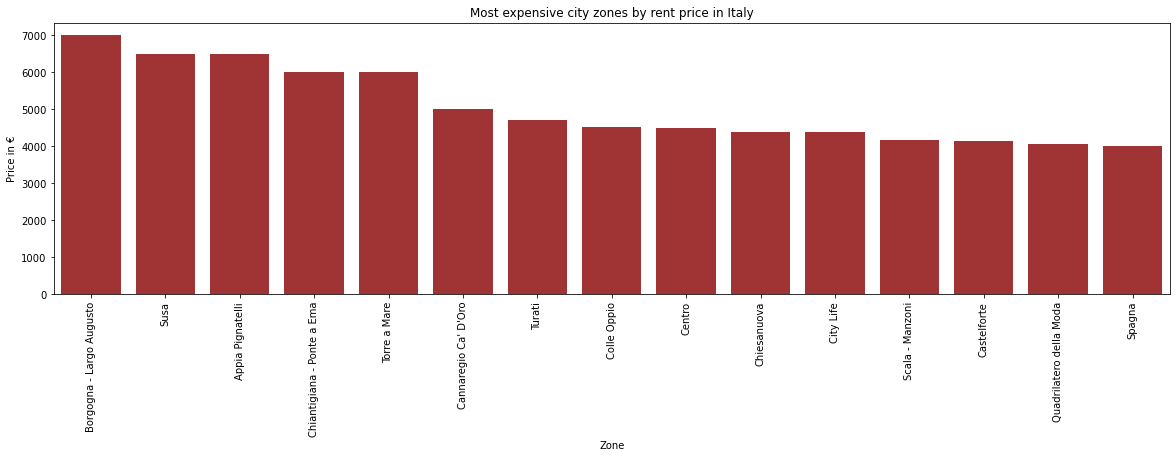

In [63]:
plt.figure(figsize=(20,5))
plt.title('Most expensive city zones by rent price in Italy')
sns.barplot(data=df_zone, x='Zone', y = 'Price', color = 'firebrick')
plt.ylabel('Price in €')
plt.xticks(rotation = 90);

##### Milano

In [64]:
df_milano = df_italia[df_italia['City']=='Milano']
milano_zone = df_milano.groupby(['Zone']).size().sort_values(ascending = False).reset_index().rename(columns={0:'Num'}).iloc[0:30]
milano_zone

,Zone,Num
0,Città Studi,72
1,Solari,56
2,Quadronno - Crocetta,45
3,Sempione,45
4,Cadorna - Castello,42
5,Vincenzo Monti,41
6,Carrobbio,39
7,Navigli - Darsena,39
8,Porta Romana - Medaglie d'Oro,37
9,Porta Venezia,37


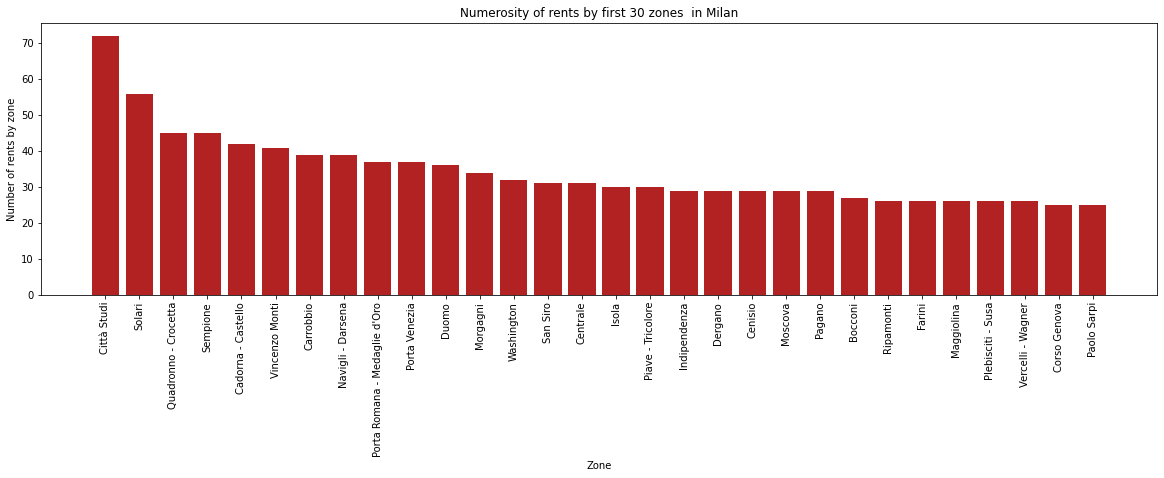

In [65]:
plt.figure(figsize=(20,5))
plt.title('Numerosity of rents by first 30 zones  in Milan')
fig = plt.bar(milano_zone['Zone'], milano_zone['Num'], color = 'firebrick')
plt.xlabel('Zone')
plt.ylabel('Number of rents by zone')
plt.xticks(rotation = 90);

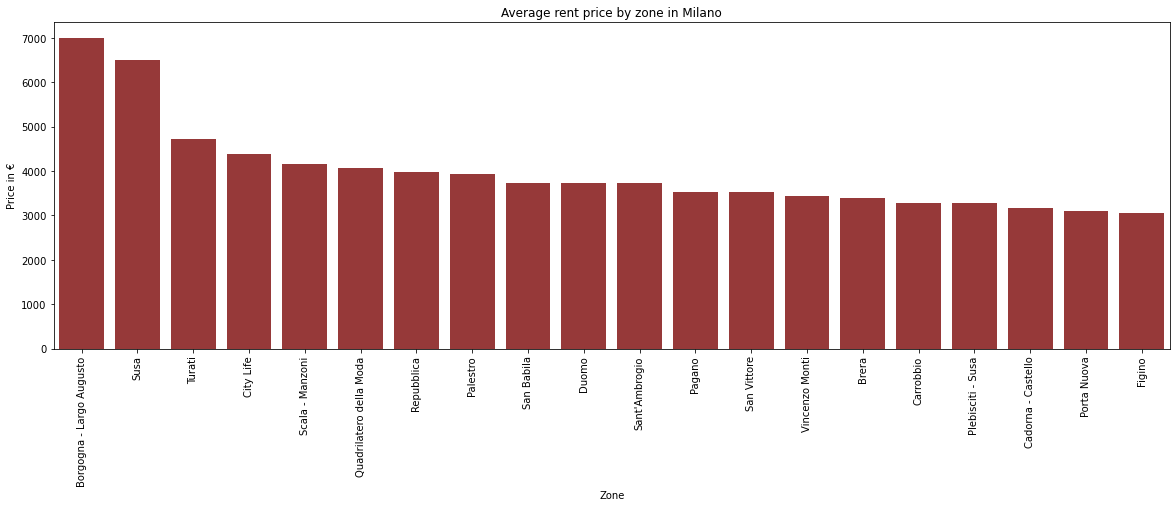

In [66]:
df_milano_zone_price = df_milano[['Zone','Price']].groupby(['Zone'])['Price'].mean().round().sort_values(ascending = False).reset_index().head(20)

plt.figure(figsize=(20,6))
sns.barplot(data = df_milano_zone_price, x = 'Zone', y = 'Price', color = 'brown')
plt.title('Average rent price by zone in Milano')
plt.ylabel('Price in €')

plt.xticks(rotation = 90);

##### Roma

In [67]:
df_roma = df_italia[df_italia['City']=='Roma']
roma_zone = df_roma.groupby(['Zone']).size().sort_values(ascending = False).reset_index().rename(columns={0:'Num'}).iloc[0:30]
roma_zone

,Zone,Num
0,Parioli,60
1,Fleming,46
2,Gregorio VII - Piccolomini,45
3,Africano - Villa Chigi,44
4,Trastevere,43
5,Sallustiano,40
6,Vigna Clara - Vigna Stelluti,39
7,Bologna,37
8,Trieste - Coppedè,35
9,Euclide,35


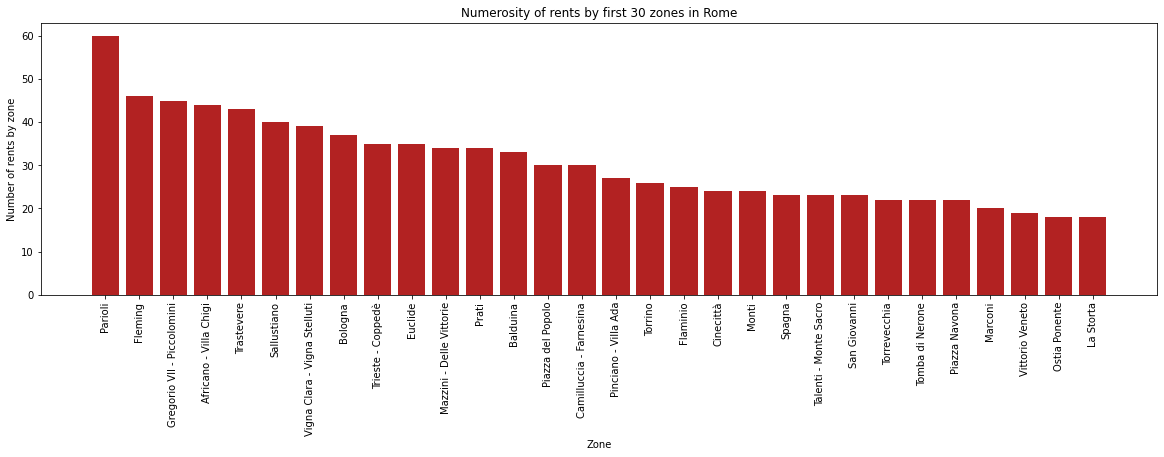

In [68]:
plt.figure(figsize=(20,5))
plt.title('Numerosity of rents by first 30 zones in Rome')
fig = plt.bar(roma_zone['Zone'], roma_zone['Num'], color = 'firebrick')
plt.xlabel('Zone')
plt.ylabel('Number of rents by zone')
plt.xticks(rotation = 90);

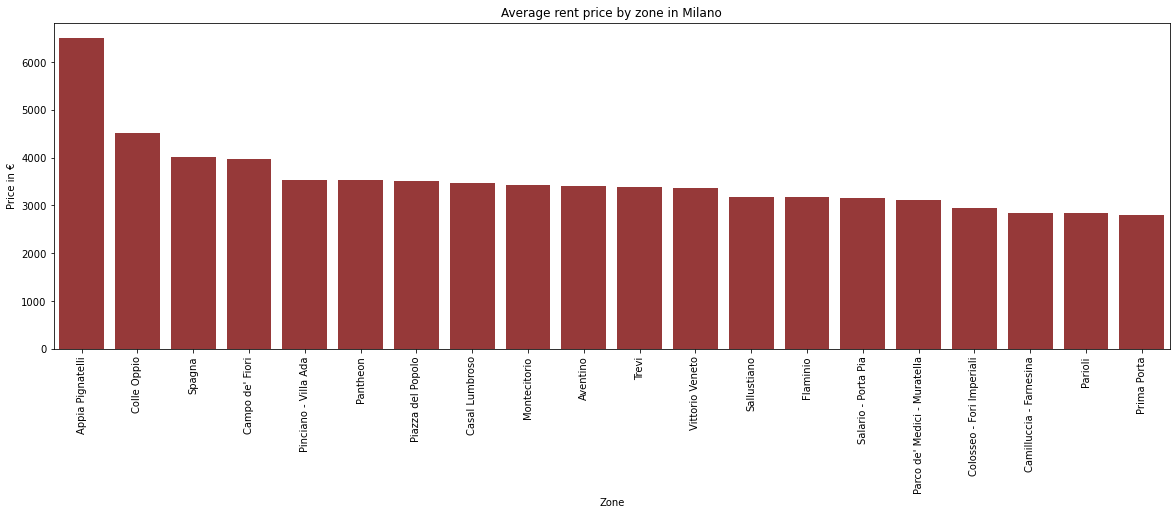

In [69]:
df_roma_zone_price = df_roma[['Zone','Price']].groupby(['Zone'])['Price'].mean().round().sort_values(ascending = False).reset_index().head(20)

plt.figure(figsize=(20,6))
sns.barplot(data = df_roma_zone_price, x = 'Zone', y = 'Price', color = 'brown')
plt.title('Average rent price by zone in Milano')
plt.ylabel('Price in €')

plt.xticks(rotation = 90);

##### Torino

In [70]:
df_torino = df_italia[df_italia['City']=='Torino']
torino_zone = df_torino.groupby(['Zone']).size().sort_values(ascending = False).reset_index().rename(columns={0:'Num'}).iloc[0:30]
torino_zone

,Zone,Num
0,Crocetta,138
1,Via Roma,124
2,Santa Rita,81
3,Cenisia,78
4,Aurora,72
5,San Salvario - Dante,64
6,Via della Rocca,61
7,Parella,60
8,Quadrilatero Romano,60
9,Vanchiglia,55


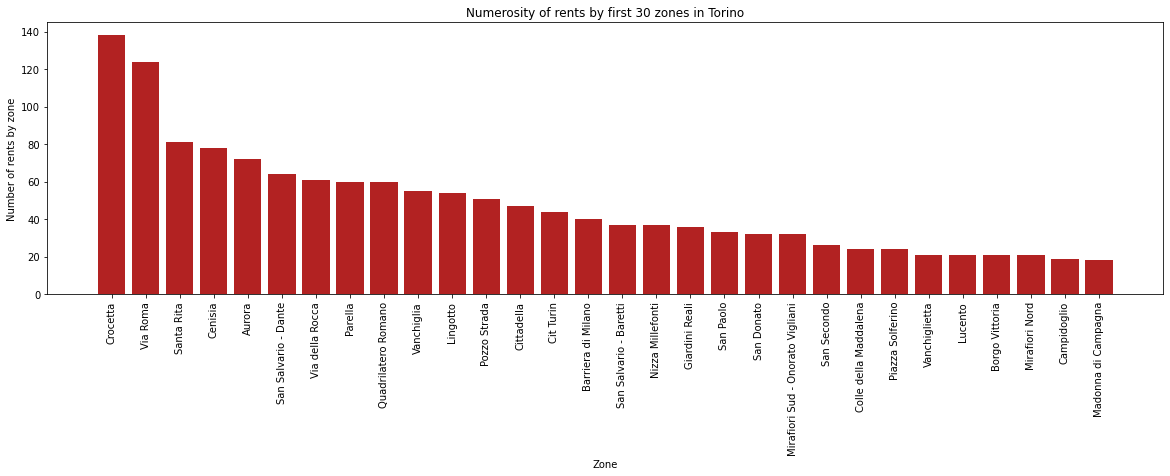

In [71]:
plt.figure(figsize=(20,5))
plt.title('Numerosity of rents by first 30 zones in Torino')
fig = plt.bar(torino_zone['Zone'], torino_zone['Num'], color = 'firebrick')
plt.xlabel('Zone')
plt.ylabel('Number of rents by zone')
plt.xticks(rotation = 90);

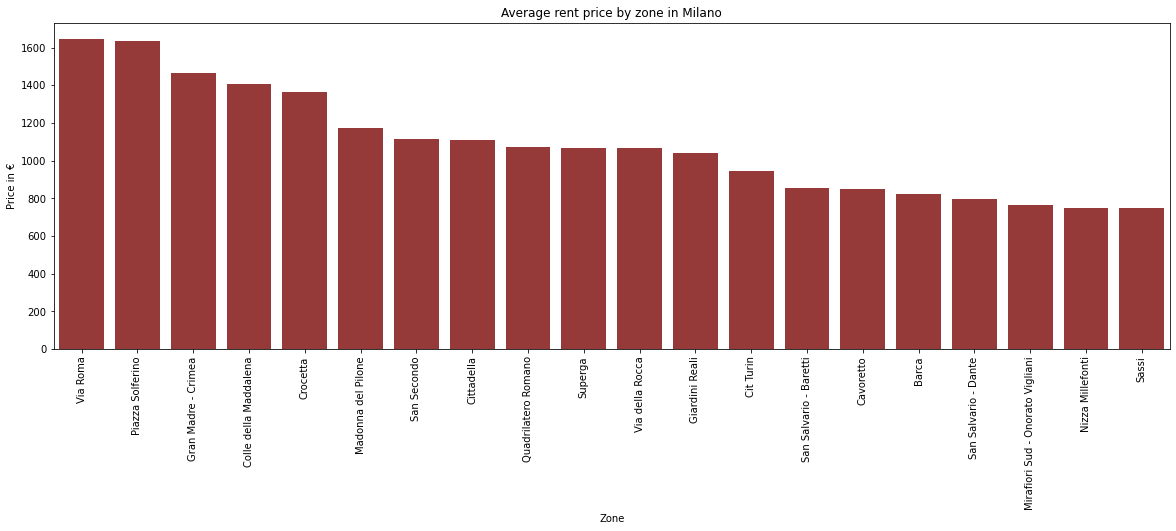

In [72]:
df_torino_zone_price = df_torino[['Zone','Price']].groupby(['Zone'])['Price'].mean().round().sort_values(ascending = False).reset_index().head(20)

plt.figure(figsize=(20,6))
sns.barplot(data = df_torino_zone_price, x = 'Zone', y = 'Price', color = 'brown')
plt.title('Average rent price by zone in Milano')
plt.ylabel('Price in €')

plt.xticks(rotation = 90);

##### Firenze

In [73]:
df_firenze = df_italia[df_italia['City']=='Firenze']
firenze_zone = df_firenze.groupby(['Zone']).size().sort_values(ascending = False).reset_index().rename(columns={0:'Num'}).iloc[0:30]
firenze_zone

,Zone,Num
0,San Marco - SS Annunziata,69
1,Duomo,57
2,Signoria - Uffizi,55
3,Piazza della Repubblica,46
4,San Frediano,45
5,Santo Spirito,43
6,Michelangelo - Poggio Imperiale,38
7,Ponte Vecchio - Pitti,37
8,Bolognese,35
9,Borgo Ognissanti - Il Prato,35


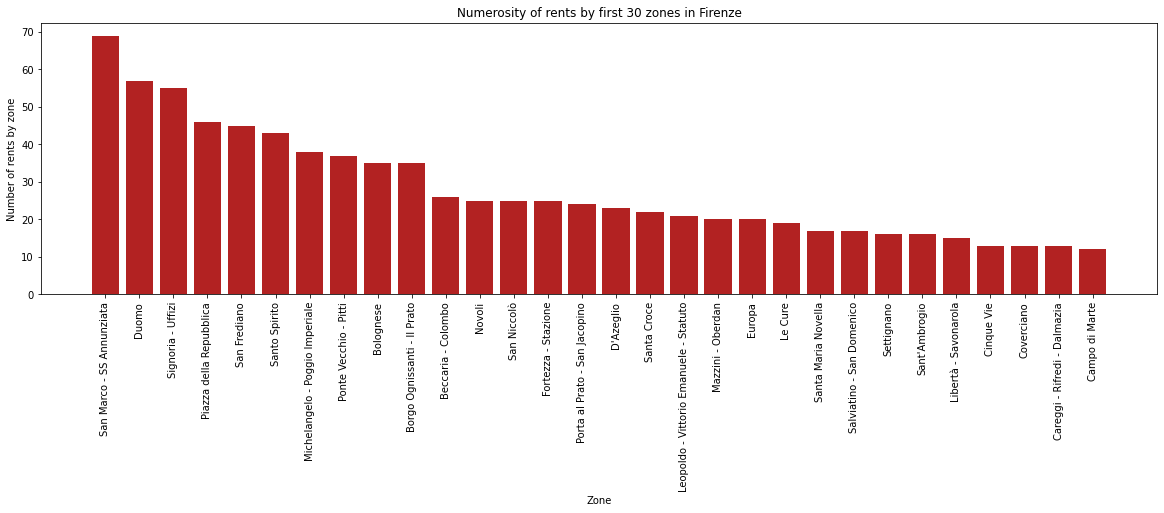

In [74]:
plt.figure(figsize=(20,5))
plt.title('Numerosity of rents by first 30 zones in Firenze')
fig = plt.bar(firenze_zone['Zone'], firenze_zone['Num'], color = 'firebrick')
plt.xlabel('Zone')
plt.ylabel('Number of rents by zone')
plt.xticks(rotation = 90);

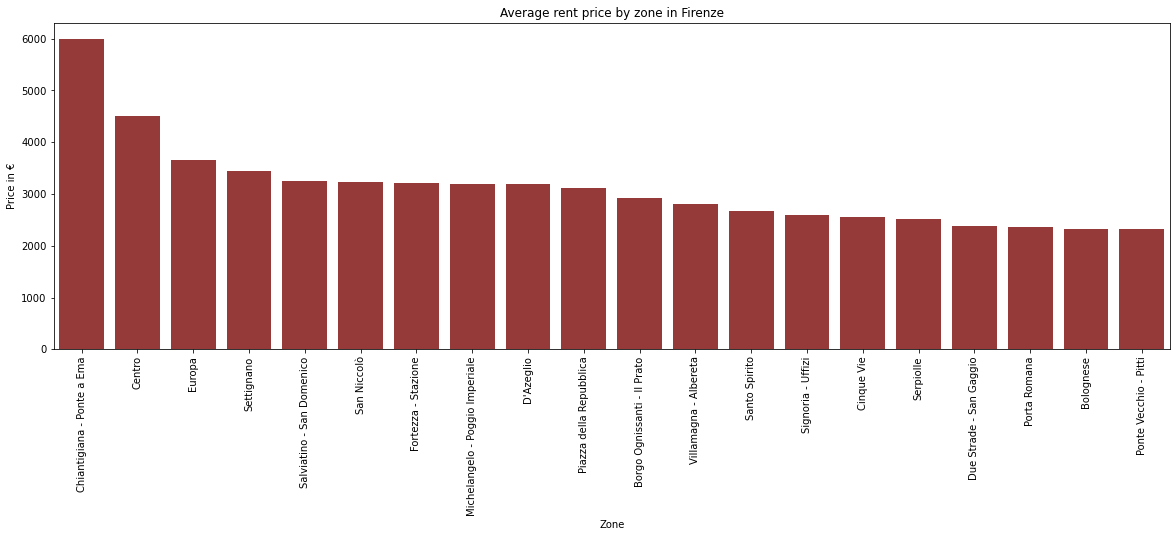

In [75]:
df_firenze_zone_price = df_firenze[['Zone','Price']].groupby(['Zone'])['Price'].mean().round().sort_values(ascending = False).reset_index().head(20)


plt.figure(figsize=(20,6))
sns.barplot(data = df_firenze_zone_price, x = 'Zone', y = 'Price', color = 'brown')
plt.title('Average rent price by zone in Firenze')
plt.ylabel('Price in €')
plt.xticks(rotation = 90);

##### Bologna

In [76]:
df_bologna = df_italia[df_italia['City']=='Bologna']
bologna_zone = df_bologna.groupby(['Zone']).size().sort_values(ascending = False).reset_index().rename(columns={0:'Num'}).iloc[0:30]
bologna_zone

,Zone,Num
0,Centro Storico,100
1,Massarenti,65
2,Bolognina,64
3,Marconi,48
4,San Felice,46
5,Mazzini - Fossolo,41
6,Santo Stefano,41
7,Irnerio,39
8,Saffi,35
9,San Donato,34


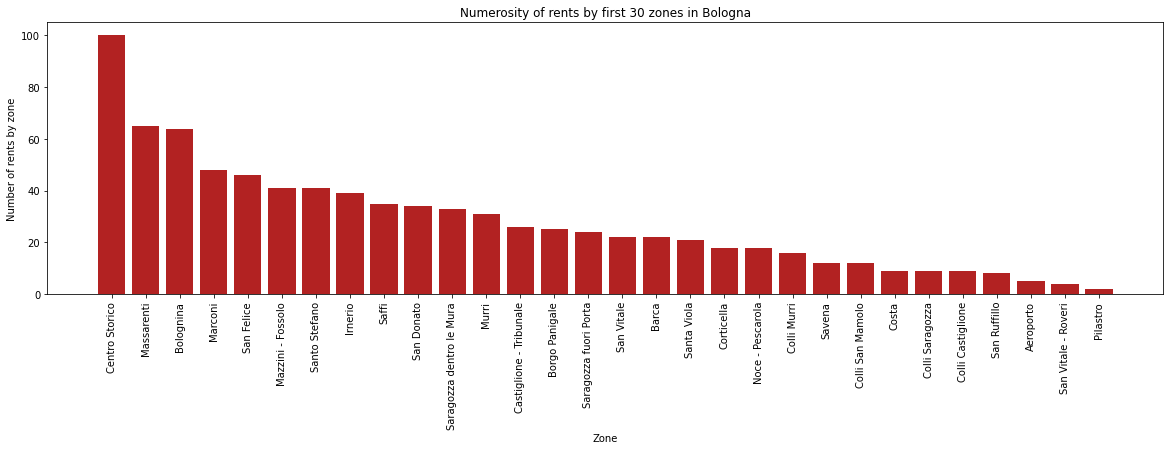

In [77]:
plt.figure(figsize=(20,5))
plt.title('Numerosity of rents by first 30 zones in Bologna')
fig = plt.bar(bologna_zone['Zone'], bologna_zone['Num'], color = 'firebrick')
plt.xlabel('Zone')
plt.ylabel('Number of rents by zone')
plt.xticks(rotation = 90);

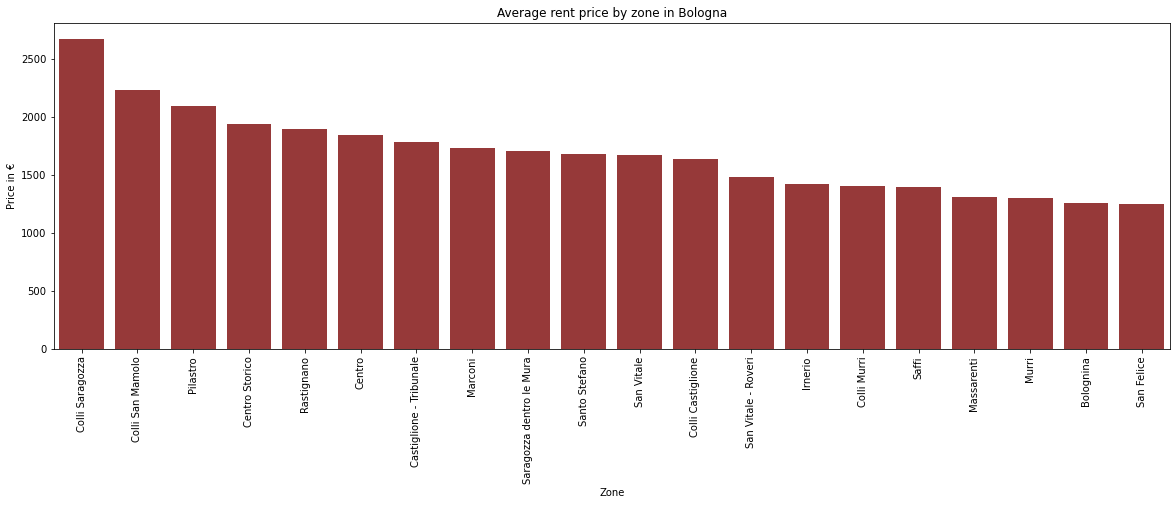

In [78]:
df_bologna_zone_price = df_bologna[['Zone','Price']].groupby(['Zone'])['Price'].mean().round().sort_values(ascending = False).reset_index().head(20)

plt.figure(figsize=(20,6))
sns.barplot(data = df_bologna_zone_price, x = 'Zone', y = 'Price', color = 'brown')
plt.title('Average rent price by zone in Bologna')
plt.ylabel('Price in €')

plt.xticks(rotation = 90);

#### Housing_unit

Here, there are some graphs that are specific for the variable Housing_unit but that have been already analyzed above

In [79]:
N_types_of_locals = df_italia.groupby(['Housing_unit']).size().sort_values(ascending = False).reset_index().rename(columns={0:'Num'})
N_types_of_locals

,Housing_unit,Num
0,Bilocale,3429
1,Trilocale,2700
2,Appartamento,1585
3,Quadrilocale,1502
4,Monolocale,1084
5,Attico,363
6,Villa,261
7,Palazzo,162
8,Mansarda,138
9,Loft,68


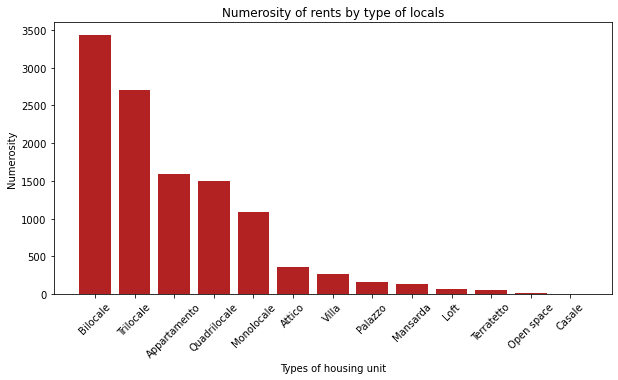

In [80]:
plt.figure(figsize=(10,5))
plt.title('Numerosity of rents by type of locals')
plt.bar(N_types_of_locals['Housing_unit'], N_types_of_locals['Num'], color = 'firebrick')
plt.xlabel('Types of housing unit')
plt.ylabel('Numerosity')
plt.xticks(rotation = 45);

In [81]:
df_italia1 = df_italia[['City', 'Housing_unit','N_rooms']].groupby(['City','Housing_unit'])['N_rooms'].count().sort_values(ascending = False).reset_index()

df1 = df_italia1[(df_italia1['Housing_unit']=='Appartamento') | (df_italia1['Housing_unit']=='Monolocale') | (df_italia1['Housing_unit']=='Bilocale') |
                (df_italia1['Housing_unit']=='Trilocale') | (df_italia1['Housing_unit']=='Quadrilocale')]

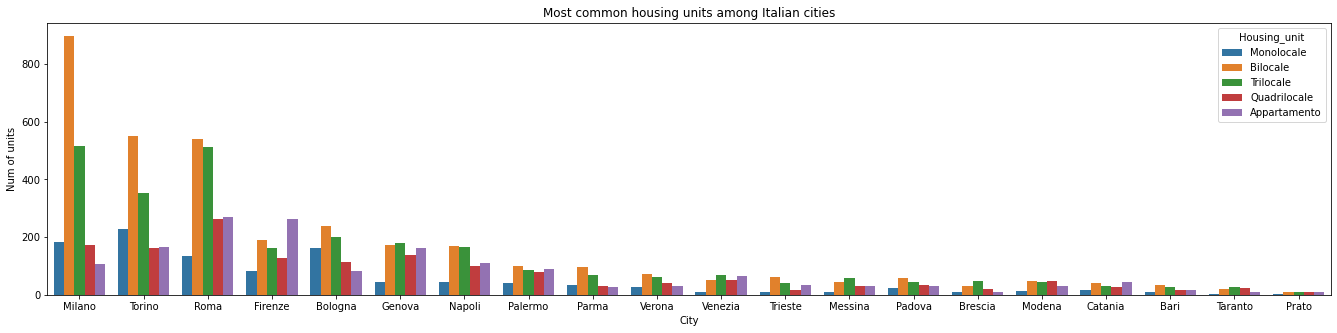

In [82]:
plt.figure(figsize=(23,5))
labels = ['Monolocale', 'Bilocale', 'Trilocale', 'Quadrilocale','Appartamento']
plt.legend(labels =['Monolocale', 'Bilocale', 'Trilocale', 'Quadrilocale','Appartamento'], loc=1)
sns.barplot(data = df1, x = 'City', y = 'N_rooms', hue = 'Housing_unit', hue_order = labels)
plt.title('Most common housing units among Italian cities')
plt.ylabel('Num of units');

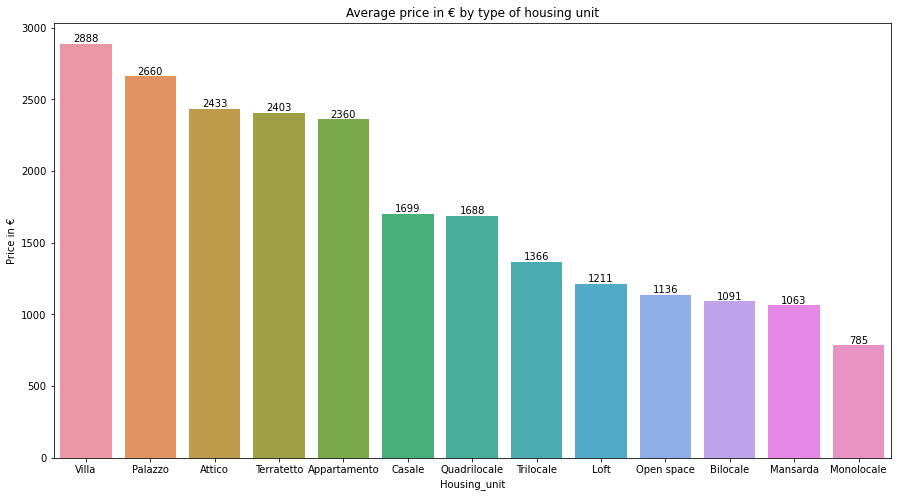

In [83]:
df_price = df_italia[['Housing_unit','Price']].groupby(['Housing_unit'])['Price'].mean().sort_values(ascending = False).round().reset_index()

plt.figure(figsize=(15, 8))
fig = sns.barplot(data = df_price, x = 'Housing_unit', y = 'Price')
plt.bar_label(fig.containers[0])
plt.ylabel('Price in €')
plt.title('Average price in € by type of housing unit');

In [84]:
df_monolocali = df_italia[df_italia['Housing_unit']=='Monolocale']
df_monolocali[['City','N_rooms']].groupby(['City'])['N_rooms'].size().sort_values(ascending = False).reset_index().head(5)

,City,N_rooms
0,Torino,228
1,Milano,183
2,Bologna,161
3,Roma,134
4,Firenze,81


In [85]:
df_bilocali = df_italia[df_italia['Housing_unit']=='Bilocale']
df_bilocali[['City','N_rooms']].groupby(['City'])['N_rooms'].size().sort_values(ascending = False).reset_index().head(5)

,City,N_rooms
0,Milano,897
1,Torino,551
2,Roma,541
3,Bologna,238
4,Firenze,190


In [86]:
df_trilocali = df_italia[df_italia['Housing_unit']=='Trilocale']
df_trilocali[['City','N_rooms']].groupby(['City'])['N_rooms'].size().sort_values(ascending = False).reset_index().head(5)

,City,N_rooms
0,Milano,515
1,Roma,512
2,Torino,352
3,Bologna,199
4,Genova,180


In [87]:
df_quadrilocali = df_italia[df_italia['Housing_unit']=='Quadrilocale']
df_quadrilocali[['City','N_rooms']].groupby(['City'])['N_rooms'].size().sort_values(ascending = False).reset_index().head(5)

,City,N_rooms
0,Roma,261
1,Milano,172
2,Torino,162
3,Genova,138
4,Firenze,128


## Remove outliers and suspicious values

Outliers are removed using the IQR and and some suspicious values are deleted. 
For suspicious values I mean those houses/flats with:
- Price rent < 150, because they are probably daily or weekly rents in B&B, while I am focusing on monthly rents 
- Surface < 20 m2, because they are more likely to be scams since they are too small to be said livable

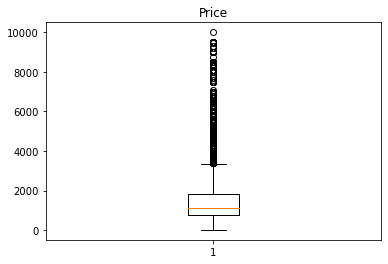

In [88]:
plt.boxplot(df_italia['Price'])
plt.title('Price');

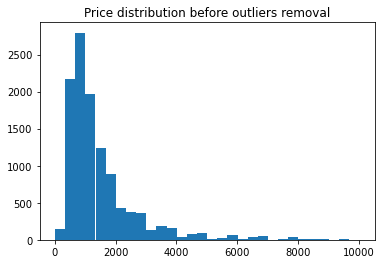

In [89]:
plt.hist(df_italia['Price'], bins = 30)
plt.title('Price distribution before outliers removal');

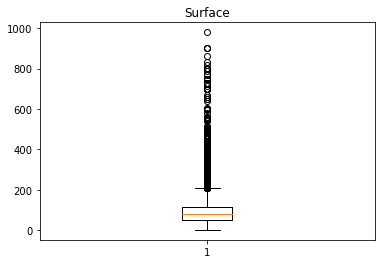

In [90]:
plt.boxplot(df_italia['Surface'])
plt.title('Surface');

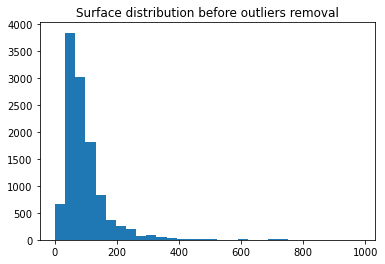

In [91]:
plt.hist(df_italia['Surface'], bins = 30)
plt.title('Surface distribution before outliers removal');

In [92]:
len(df_italia[df_italia['Price']<250]), len(df_italia[df_italia['Surface']<20])

(36, 152)

In [93]:
#Removing suspicious values, that could be scam announcements or daily/weekly rents in B&B
df_italia =df_italia[(df_italia['Surface']>=20) & (df_italia['Price']>=250)]

In [94]:
df_italia.shape

(11190, 7)

In [95]:
def remove_outliers_iqr(df,columns):
    for col in columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


columns_to_check = ['Price','Surface']
df_cleaned = remove_outliers_iqr(df_italia, columns_to_check)

df_cleaned.head()

,Price,N_rooms,Surface,Floor,City,Zone,Housing_unit
1,1150.0,1,40.0,3,Milano,Buenos Aires,Monolocale
2,900.0,2,51.0,3,Milano,Bovisa,Bilocale
3,1550.0,2,55.0,3,Milano,Missori,Bilocale
4,920.0,2,45.0,3,Milano,Città Studi,Bilocale
5,2975.0,4,150.0,3,Milano,Centrale,Quadrilocale


In [96]:
df_cleaned.shape

(9877, 7)

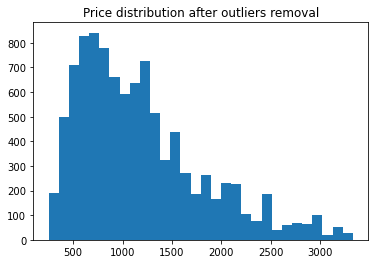

In [97]:
plt.hist(df_cleaned['Price'], bins = 30)
plt.title('Price distribution after outliers removal');

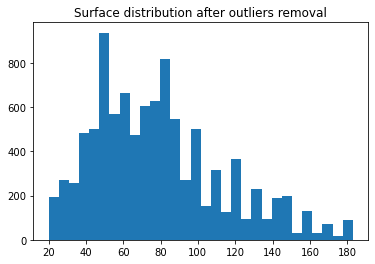

In [98]:
plt.hist(df_cleaned['Surface'], bins = 30)
plt.title('Surface distribution after outliers removal');

## Encoding

In [99]:
label = LabelEncoder()

df_cleaned[['N_rooms', 'Floor', 'City', 'Zone','Housing_unit']] = df_cleaned[['N_rooms', 
                                                                'Floor', 'City','Zone','Housing_unit']].apply(label.fit_transform)

df_cleaned.head()

,Price,N_rooms,Surface,Floor,City,Zone,Housing_unit
1,1150.0,0,40.0,5,7,105,6
2,900.0,1,51.0,5,7,97,2
3,1550.0,1,55.0,5,7,403,2
4,920.0,1,45.0,5,7,204,2
5,2975.0,3,150.0,5,7,174,9


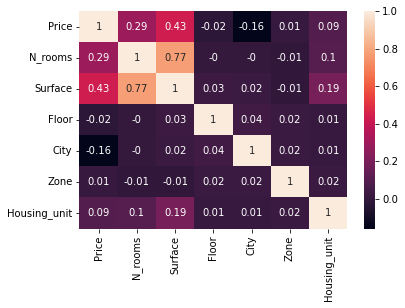

In [100]:
matrix = df_cleaned.corr().round(2)
sns.heatmap(matrix, annot=True);

# Model Building

## Data preparation

The machine learning algoritms used for model building are Decision Tree, Random Forest, XGBoost and LGBM; the last two are gradient boosting backed algorithms. All of them have a regressor option that was used to predict the rent price.

in particulare, LGBM has a specific procedure for data preparation that require to transform numerical variables into float variables

In [101]:
X = df_cleaned.drop(columns = 'Price', axis = 1)
Y = df_cleaned['Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)
X_train.shape, X_test.shape, X.shape

((6913, 6), (2964, 6), (9877, 6))

## Decision Tree

In [102]:
dt = DecisionTreeRegressor()

start_time = time.time()


param_grid ={
    'max_depth':[2,4,6,8],
    'min_samples_split': [2,4,6,8],
    'min_samples_leaf': [1,2,3,4],
    'max_features': ['auto','sqrt','log2'],
    'random_state': [0,42]
}

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring = 'neg_mean_squared_error') 

grid_search.fit(X_train , Y_train )

print(grid_search.best_params_)

end_time = time.time()
duration = end_time - start_time
print(duration/60)

{'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 0}
0.5149002949396769


In [141]:
dt = DecisionTreeRegressor(max_depth=8, max_features='auto', min_samples_leaf=4, min_samples_split=2, random_state=0)
dt.fit(X_train , Y_train )

y_train_pred = dt.predict(X_train)

mae = round(mean_absolute_error(Y_train,y_train_pred), 2) 
mse = round(mean_squared_error(Y_train,y_train_pred), 2)
mape = round(mean_absolute_percentage_error(Y_train,y_train_pred)*100,2)
r2 =round(r2_score(Y_train,y_train_pred)*100,2)
rmse = round( math.sqrt(mse), 2)


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")

MAE is: 291.37
MSE is: 162195.99
MAPE is: 27.96
R2 SCORE is: 59.61
RMSE is: 402.74


In [142]:
y_pred = dt.predict(X_test)

mae = round(mean_absolute_error(Y_test,y_pred),2)
mse = round(mean_squared_error(Y_test,y_pred),2)
mape = round(mean_absolute_percentage_error(Y_test,y_pred)*100,2)
r2 = round(r2_score(Y_test,y_pred),2)*100
rmse = round(math.sqrt(mse),2)


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")


df_metrics = pd.DataFrame()
df_metrics = df_metrics.append({'Algorithm':'Decision Tree Regressor', 'MAE €':mae, 'MSE €': mse,  'RMSE €': rmse, 'MAPE %': mape, 'R2 Score %': r2}, ignore_index=True)

MAE is: 313.8
MSE is: 189793.85
MAPE is: 30.15
R2 SCORE is: 53.0
RMSE is: 435.65


## Random Forest

In [105]:
rf = RandomForestClassifier()


start_time = time.time()

RANDOM_STATE = 42

param_grid ={
     'n_estimators':[ 50, 100, 150],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8],
    'max_features': [1.0, 2.0, 3.0],
    'max_depth': [5, 10, 20],
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring = 'neg_mean_squared_error') 

grid_search.fit(X_train , Y_train )

print(grid_search.best_params_)

end_time = time.time()
duration = end_time - start_time
print(duration/60)

{'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
66.5092515707016


In [143]:
RANDOM_STATE = 42

rf = RandomForestClassifier(n_estimators= 150, min_samples_split= 2 , min_samples_leaf= 4, max_features= 1.0, max_depth = 10, random_state=RANDOM_STATE)
rf.fit(X_train , Y_train )

y_train_pred = rf.predict(X_train)

mae = round(mean_absolute_error(Y_train,y_train_pred), 2) 
mse = round(mean_squared_error(Y_train,y_train_pred) , 2) 
mape = round(mean_absolute_percentage_error(Y_train,y_train_pred)*100,2)
r2 = round(r2_score(Y_train,y_train_pred)*100,2)
rmse = round(math.sqrt(mse) , 2) 


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")

MAE is: 233.57
MSE is: 186547.29
MAPE is: 20.19
R2 SCORE is: 53.55
RMSE is: 431.91


In [144]:
y_pred = rf.predict(X_test)

mae = round( mean_absolute_error(Y_test,y_pred), 2) 
mse = round(mean_squared_error(Y_test,y_pred), 2) 
mape = round(mean_absolute_percentage_error(Y_test,y_pred)*100,2)
r2 = round(r2_score(Y_test,y_pred), 2)*100
rmse = round(math.sqrt(mse), 2) 


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")


df_metrics = df_metrics.append({'Algorithm':'Random Forest Regressor', 'MAE €':mae, 'MSE €': mse,  'RMSE €': rmse, 'MAPE %': mape, 'R2 Score %': r2 }, ignore_index=True)

MAE is: 334.25
MSE is: 255297.97
MAPE is: 29.52
R2 SCORE is: 37.0
RMSE is: 505.27


## XGBoost

In [124]:
xgb = XGBRegressor()

start_time = time.time()


param_grid ={
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring = 'neg_mean_squared_error') 

grid_search.fit(X_train , Y_train )

print(grid_search.best_params_)

end_time = time.time()
duration = end_time - start_time
print(duration/60)

{'learning_rate': 0.1, 'n_estimators': 150}
0.4076710025469462


In [145]:
xgb = XGBRegressor(n_estimators= 150, eta=0.1)
xgb.fit(X_train , Y_train )

y_train_pred = xgb.predict(X_train)

mae = round( mean_absolute_error(Y_train,y_train_pred), 2)
mse = round(mean_squared_error(Y_train,y_train_pred), 2)
mape = round(mean_absolute_percentage_error(Y_train,y_train_pred)*100,2)
r2 = round(r2_score(Y_train,y_train_pred)*100,2)
rmse = round(math.sqrt(mse), 2)


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")

MAE is: 226.73
MSE is: 100726.56
MAPE is: 21.81
R2 SCORE is: 74.92
RMSE is: 317.37


In [146]:
y_pred = xgb.predict(X_test)

mae = round(mean_absolute_error(Y_test,y_pred), 2)
mse = round(mean_squared_error(Y_test,y_pred), 2)
mape = round(mean_absolute_percentage_error(Y_test,y_pred)*100,2)
r2 = round(r2_score(Y_test,y_pred) , 2)*100
rmse = round(math.sqrt(mse) , 2)


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")

df_metrics = df_metrics.append({'Algorithm':'XGB Regressor', 'MAE €':mae, 'MSE €': mse,  'RMSE €': rmse, 'MAPE %': mape, 'R2 Score %': r2 }, ignore_index=True)

MAE is: 277.89
MSE is: 153864.5
MAPE is: 26.87
R2 SCORE is: 62.0
RMSE is: 392.26


## LGBM

In [127]:
lgbm = LGBMRegressor()

param_grid ={
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1]
}


grid_search = GridSearchCV(lgbm, param_grid, cv=5, scoring = 'neg_mean_squared_error') 

grid_search.fit(X_train , Y_train )

print(grid_search.best_params_)

{'learning_rate': 0.1, 'n_estimators': 150}


In [147]:
# With the LGBM algorithm numerical variables need to be trasnformed into float variables
X_train = X_train.astype(float)
X_test = X_test.astype(float)
Y_train = Y_train.astype(float)
Y_test = Y_test.astype(float)


lgbm = LGBMRegressor(n_estimators= 150 ,learning_rate=0.1)
lgbm.fit(X_train , Y_train )

y_train_pred = lgbm.predict(X_train)

mae = round( mean_absolute_error(Y_train,y_train_pred), 2)
mse = round(mean_squared_error(Y_train,y_train_pred), 2)
mape = round(mean_absolute_percentage_error(Y_train,y_train_pred)*100,2)
r2 = round(r2_score(Y_train,y_train_pred)*100,2)
rmse = round(math.sqrt(mse), 2)


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")

MAE is: 240.82
MSE is: 112998.81
MAPE is: 23.12
R2 SCORE is: 71.86
RMSE is: 336.15


In [148]:
y_pred = lgbm.predict(X_test)

mae = round(mean_absolute_error(Y_test,y_pred), 2)
mse = round(mean_squared_error(Y_test,y_pred), 2)
mape = round(mean_absolute_percentage_error(Y_test,y_pred)*100,2)
r2 = round(r2_score(Y_test,y_pred), 2)*100
rmse =round( math.sqrt(mse), 2)


print(f"MAE is: {mae}")
print(f"MSE is: {mse}")
print(f"MAPE is: {mape}")
print(f"R2 SCORE is: {r2}")
print(f"RMSE is: {rmse}")

df_metrics = df_metrics.append({'Algorithm':'LGBM Regressor', 'MAE €':mae, 'MSE €': mse,  'RMSE €': rmse, 'MAPE %': mape, 'R2 Score %': r2 }, ignore_index=True)

MAE is: 281.42
MSE is: 156052.14
MAPE is: 27.16
R2 SCORE is: 61.0
RMSE is: 395.03


In [149]:
df_metrics

,Algorithm,MAE €,MSE €,RMSE €,MAPE %,R2 Score %
0,Decision Tree Regressor,313.80,189793.85,435.65,30.15,53.0
1,Random Forest Regressor,334.25,255297.97,505.27,29.52,37.0
2,XGB Regressor,277.89,153864.50,392.26,26.87,62.0
3,LGBM Regressor,281.42,156052.14,395.03,27.16,61.0


##### Observation:

We can see that the model built with the XGB Regressor is the best performing one among the models used, because it obtained the minimum score of MAE (277.89 €), MSE (153864.50 €), RMSE (392.26 €), and the highest R2 score (62%). 

Nevertheless, we can see that the absolute errors are high due to the high variance among Price and Surface variables. Other reasons can be the fact that there are 20 different rent markets from the 20 different cities selected and that the several housing unit types with distinctive characteristcs are considered. All of these may increase the Price variance.

In [115]:
cities_list = df_italia['City'].unique().tolist()
cities_list

['Milano',
 'Roma',
 'Torino',
 'Genova',
 'Napoli',
 'Palermo',
 'Bologna',
 'Firenze',
 'Bari',
 'Catania',
 'Verona',
 'Venezia',
 'Messina',
 'Padova',
 'Trieste',
 'Parma',
 'Brescia',
 'Prato',
 'Taranto',
 'Modena']

In [116]:
df_genova = df_italia[df_italia['City']=='Genova']
df_palermo = df_italia[df_italia['City']=='Palermo']
df_napoli = df_italia[df_italia['City']=='Napoli']
df_bari = df_italia[df_italia['City']=='Bari']
df_catania = df_italia[df_italia['City']=='Catania']
df_verona = df_italia[df_italia['City']=='Verona']

df_messina = df_italia[df_italia['City']=='Messina']

df_venezia = df_italia[df_italia['City']=='Venezia']
df_padova = df_italia[df_italia['City']=='Padova']
df_trieste = df_italia[df_italia['City']=='Trieste']
df_parma = df_italia[df_italia['City']=='Parma']
df_brescia = df_italia[df_italia['City']=='Brescia']
df_prato = df_italia[df_italia['City']=='Prato']

df_taranto = df_italia[df_italia['City']=='Taranto']
df_modena = df_italia[df_italia['City']=='Modena']


In [117]:
cities = [df_milano, df_roma, df_torino, df_bologna, df_firenze,
        df_genova,df_palermo, df_napoli, df_bari, df_catania, df_verona, df_messina, df_venezia, 
        df_padova, df_trieste, df_parma, df_brescia, df_prato, df_taranto, df_modena]

In [118]:
len(cities)

20

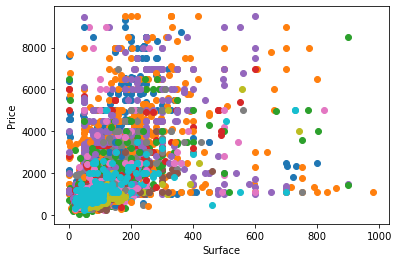

In [119]:
for city in cities: 
    #plt.figure(figsize=(5,5))
    #print(city['City'].unique())
    plt.scatter(city['Surface'], city['Price'])
    plt.xlabel('Surface')
    plt.ylabel('Price');

In [120]:
df_italia.shape

(11190, 7)

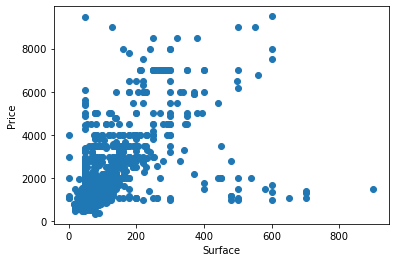

In [121]:
plt.scatter(df_firenze['Surface'], df_firenze['Price'])
plt.xlabel('Surface')
plt.ylabel('Price');